<a href="https://colab.research.google.com/github/IsakLarsson/Deep-Learning-labs/blob/main/Del_2_text_processing_Isak_%C3%85man_Larsson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.4.3'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [ ]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 80000 # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
EPOCHS = 40

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [ ]:
from keras.layers import Dense
from keras.callbacks import EarlyStopping

earlystop= EarlyStopping(monitor='val_loss',
                         patience=3, 
                         min_delta=0, 
                         restore_best_weights=True) #definiera early stop

modelRNN = Sequential()
modelRNN.add(Embedding(max_features, 32))
modelRNN.add(SimpleRNN(32))
modelRNN.add(Dense(1, activation='sigmoid'))

modelRNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


history = modelRNN.fit(input_train, y_train,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[earlystop])




Epoch 1/40
157/157 [==============================] - 56s 355ms/step - loss: 0.6419 - acc: 0.6122 - val_loss: 0.7147 - val_acc: 0.6134
Epoch 2/40
157/157 [==============================] - 54s 347ms/step - loss: 0.4231 - acc: 0.8189 - val_loss: 0.3895 - val_acc: 0.8382
Epoch 3/40
157/157 [==============================] - 54s 344ms/step - loss: 0.2682 - acc: 0.8954 - val_loss: 0.3988 - val_acc: 0.8428
Epoch 4/40
157/157 [==============================] - 55s 347ms/step - loss: 0.1867 - acc: 0.9308 - val_loss: 0.3784 - val_acc: 0.8502
Epoch 5/40
157/157 [==============================] - 55s 353ms/step - loss: 0.1340 - acc: 0.9532 - val_loss: 0.4038 - val_acc: 0.8500
Epoch 6/40
157/157 [==============================] - 55s 348ms/step - loss: 0.0781 - acc: 0.9727 - val_loss: 0.4745 - val_acc: 0.8202
Epoch 7/40
157/157 [==============================] - 54s 345ms/step - loss: 0.0440 - acc: 0.9862 - val_loss: 0.4568 - val_acc: 0.8582


Let's display the training and validation loss and accuracy:

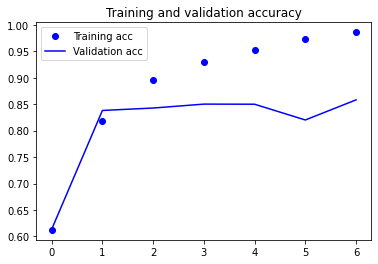

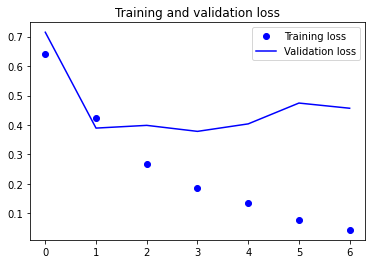

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [ ]:
from keras.layers import LSTM

modelLSTM = Sequential()
modelLSTM.add(Embedding(max_features, 32))
modelLSTM.add(LSTM(32))
modelLSTM.add(Dense(1, activation='sigmoid'))

modelLSTM.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = modelLSTM.fit(input_train, y_train,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[earlystop])



Epoch 1/40
157/157 [==============================] - 6s 38ms/step - loss: 0.4923 - acc: 0.7736 - val_loss: 0.4621 - val_acc: 0.7882
Epoch 2/40
157/157 [==============================] - 6s 35ms/step - loss: 0.2766 - acc: 0.8967 - val_loss: 0.3786 - val_acc: 0.8544
Epoch 3/40
157/157 [==============================] - 6s 35ms/step - loss: 0.1971 - acc: 0.9296 - val_loss: 0.3603 - val_acc: 0.8422
Epoch 4/40
157/157 [==============================] - 6s 36ms/step - loss: 0.1434 - acc: 0.9507 - val_loss: 0.2899 - val_acc: 0.8940
Epoch 5/40
157/157 [==============================] - 5s 34ms/step - loss: 0.1109 - acc: 0.9624 - val_loss: 0.3663 - val_acc: 0.8738
Epoch 6/40
157/157 [==============================] - 5s 34ms/step - loss: 0.0876 - acc: 0.9707 - val_loss: 0.3311 - val_acc: 0.8860
Epoch 7/40
157/157 [==============================] - 5s 33ms/step - loss: 0.0664 - acc: 0.9786 - val_loss: 0.5438 - val_acc: 0.8172


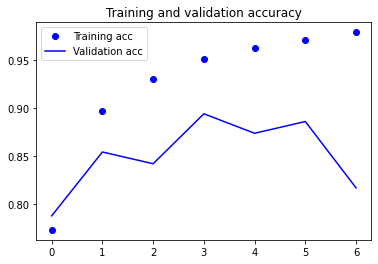

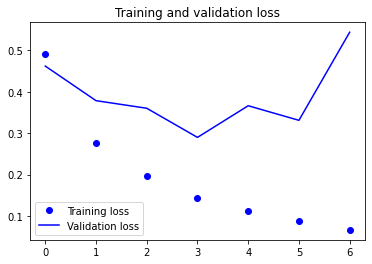

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Egen implementation

De övre modellerna verkar overfitta en del då de når nästan 100% training accuracy och av graferna att döma så går lossen upp väldigt fort. implementerat early stopping nu.

Sparar ned de tidigare modellernas resultat

In [ ]:
models_performance = {}

models_performance["Simple RNN"]=modelRNN.evaluate(input_test, y_test)
models_performance["LSTM(32)"]=modelLSTM.evaluate(input_test, y_test)




782/782 [==============================] - 7s 9ms/step - loss: 0.3457 - acc: 0.8747


##LSTM(128)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.optimizer.lr = 0.0001 ##Learning rate

history = model.fit(input_train, y_train,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[earlystop])

models_performance["LSTM(128)"]=model.evaluate(input_test, y_test)

Epoch 1/40
157/157 [==============================] - 8s 52ms/step - loss: 0.6875 - acc: 0.5756 - val_loss: 0.6600 - val_acc: 0.6396
Epoch 2/40
157/157 [==============================] - 8s 48ms/step - loss: 0.6213 - acc: 0.7171 - val_loss: 0.6031 - val_acc: 0.6176
Epoch 3/40
157/157 [==============================] - 8s 48ms/step - loss: 0.5195 - acc: 0.7821 - val_loss: 0.5352 - val_acc: 0.7128
Epoch 4/40
157/157 [==============================] - 8s 48ms/step - loss: 0.4144 - acc: 0.8488 - val_loss: 0.3897 - val_acc: 0.8516
Epoch 5/40
157/157 [==============================] - 8s 48ms/step - loss: 0.3405 - acc: 0.8846 - val_loss: 0.4202 - val_acc: 0.8604
Epoch 6/40
157/157 [==============================] - 8s 48ms/step - loss: 0.2925 - acc: 0.8983 - val_loss: 0.3543 - val_acc: 0.8660
Epoch 7/40
157/157 [==============================] - 8s 48ms/step - loss: 0.2530 - acc: 0.9091 - val_loss: 0.3651 - val_acc: 0.8602
Epoch 8/40
157/157 [==============================] - 8s 48ms/step - 

Printa historiken

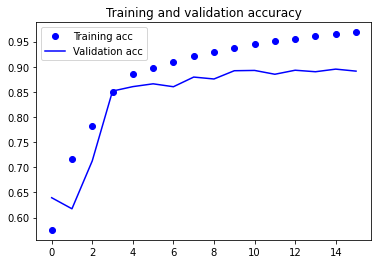

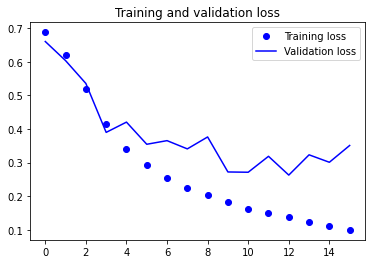

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Bidirectional LSTM(32)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features, 32),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.optimizer.lr = 0.0001 ##Learning rate

history = model.fit(input_train, y_train,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[earlystop])

models_performance["Bidirectional LSTM(32)"]=model.evaluate(input_test, y_test)

Epoch 1/40
157/157 [==============================] - 9s 59ms/step - loss: 0.6922 - acc: 0.5511 - val_loss: 0.6906 - val_acc: 0.6190
Epoch 2/40
157/157 [==============================] - 8s 54ms/step - loss: 0.6826 - acc: 0.6418 - val_loss: 0.6450 - val_acc: 0.5674
Epoch 3/40
157/157 [==============================] - 8s 53ms/step - loss: 0.5969 - acc: 0.7215 - val_loss: 0.5686 - val_acc: 0.7578
Epoch 4/40
157/157 [==============================] - 8s 54ms/step - loss: 0.5257 - acc: 0.7878 - val_loss: 0.5199 - val_acc: 0.7752
Epoch 5/40
157/157 [==============================] - 9s 54ms/step - loss: 0.4840 - acc: 0.8089 - val_loss: 0.4860 - val_acc: 0.7912
Epoch 6/40
157/157 [==============================] - 8s 53ms/step - loss: 0.4596 - acc: 0.8137 - val_loss: 0.5352 - val_acc: 0.7398
Epoch 7/40
157/157 [==============================] - 8s 54ms/step - loss: 0.4192 - acc: 0.8330 - val_loss: 0.4685 - val_acc: 0.8142
Epoch 8/40
157/157 [==============================] - 8s 54ms/step - 

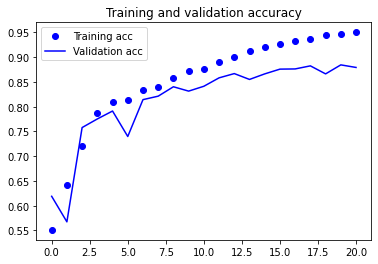

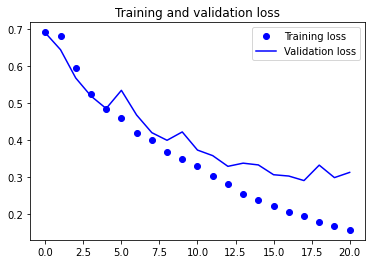

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Större LSTM

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features, 32),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), #Wrappa LSTM cellen i en bidirectional cell
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.optimizer.lr = 0.0001 ##Learning rate
history = model.fit(input_train, y_train,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[earlystop])

models_performance["Larger LSTM"]=model.evaluate(input_test, y_test)

Epoch 1/40
157/157 [==============================] - 17s 106ms/step - loss: 0.6824 - acc: 0.5831 - val_loss: 0.6321 - val_acc: 0.6754
Epoch 2/40
157/157 [==============================] - 16s 100ms/step - loss: 0.4867 - acc: 0.7840 - val_loss: 0.4039 - val_acc: 0.8230
Epoch 3/40
157/157 [==============================] - 16s 102ms/step - loss: 0.3511 - acc: 0.8543 - val_loss: 0.4294 - val_acc: 0.8108
Epoch 4/40
157/157 [==============================] - 16s 100ms/step - loss: 0.2799 - acc: 0.8900 - val_loss: 0.3152 - val_acc: 0.8676
Epoch 5/40
157/157 [==============================] - 16s 101ms/step - loss: 0.2270 - acc: 0.9141 - val_loss: 0.3836 - val_acc: 0.8354
Epoch 6/40
157/157 [==============================] - 16s 101ms/step - loss: 0.1899 - acc: 0.9306 - val_loss: 0.2901 - val_acc: 0.8848
Epoch 7/40
157/157 [==============================] - 16s 101ms/step - loss: 0.1602 - acc: 0.9410 - val_loss: 0.4417 - val_acc: 0.8446
Epoch 8/40
157/157 [==============================] - 1

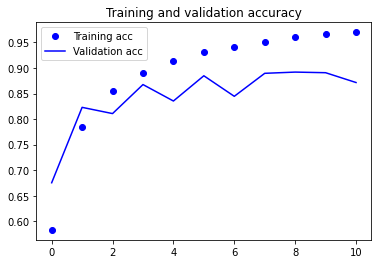

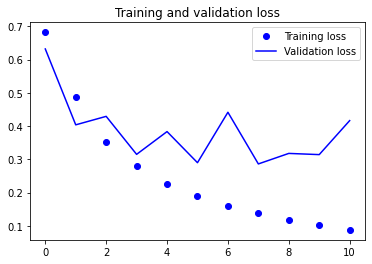

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Jämför resultaten mot varandra

In [ ]:
for key in models_performance:
  print("------------------")
  print("Model name: ",key)
  print("Model performance: %.3f" % models_performance[key][1])
  print("------------------\n")


------------------
Model name:  Simple RNN
Model performance: 0.838
------------------

------------------
Model name:  LSTM(32)
Model performance: 0.875
------------------

------------------
Model name:  LSTM(128)
Model performance: 0.880
------------------

------------------
Model name:  Bidirectional LSTM(32)
Model performance: 0.868
------------------

------------------
Model name:  Larger LSTM
Model performance: 0.874
------------------



##Testa på nya meningar

In [ ]:
test_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "This movie is not worth the money",
  "The only positive thing with this movie is the music",
]

In [ ]:
#städa upp datan från spec tecken och stora bokstäver
i = 0
for sentence in test_sentences:
  test_sentences[i] = sentence.lower().replace('!', '')
  i = i+1

In [ ]:
from keras.datasets import imdb

#Hämta imdb datats word index för att slå upp orden
word_to_id = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Nu måste vi mappa alla ord i test meningarna till deras respektiva kodning i IMDB datasetet för att kunna göra predictions på dem.

In [ ]:
import numpy as np
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize


#Mappa alla ord i de nya meningarna mot deras respektive kodning i imdb setet
test_lines_encoded = list()
for review in test_sentences:
  word_list = []
  tokenized_words = word_tokenize(review)
  for word in tokenized_words:
    word_list.append(word_to_id[word])

  test_lines_encoded.append(word_list)


arr = np.array(test_lines_encoded)
arr = sequence.pad_sequences(arr, maxlen=maxlen)

print(arr.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
(6, 500)


Utför predictions på det nya datat

In [ ]:
predictions = model.predict(arr)
print(predictions)

i = 0
for prediction in predictions:
  if(prediction >0.5):
    print(test_sentences[i], "---> Was predicted as positive   " , prediction, "\n" )
  else:
    print(test_sentences[i], "---> Was predicted as negative   " , prediction, "\n" )

  i = i+1

[[0.78217566]
 [0.8906045 ]
 [0.8275325 ]
 [0.86247164]
 [0.8987372 ]
 [0.6247293 ]]
that movie was absolutely awful ---> Was predicted as positive    [0.78217566] 

the acting was a bit lacking ---> Was predicted as positive    [0.8906045] 

the film was creative and surprising ---> Was predicted as positive    [0.8275325] 

absolutely fantastic ---> Was predicted as positive    [0.86247164] 

this movie is not worth the money ---> Was predicted as positive    [0.8987372] 

the only positive thing with this movie is the music ---> Was predicted as positive    [0.6247293] 



Jag vet inte om det är något fel på prediction modellen eller om jag matar in felaktig data men den verkar väldigt dålig på att predicta positiv/negativ på ny data. Detta kan man tänka sig beror på att dessa nya reviews är mycket kortare än de som modellen tränat på. Men jag har även testat en lång positiv review tagen direkt ur test setet, vilken predictas (0.09) alltså negativt med stor sannolikhet. Jag är lite konfunderad i detta lag. Inte fått något svar angående detta på forumet eller från lärare så den får vara såhär nu helt enkelt.

Vidare är det väldigt olika predictions varje gång man tränar om modellen, ena gången kan den predicta alla som positiva och andra gången alla som negativa...
